## Predict Restaurant Menu Items Profitability

In [5]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# improt libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

plt.style.use('ggplot')

plt.rcParams['figure.dpi'] = 150

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [7]:
# load data

df = pd.read_csv('restaurant_menu_optimization_data.csv')

In [8]:
df.head()

,RestaurantID,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",29.55,High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",17.73,Medium


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RestaurantID   1000 non-null   object 
 1   MenuCategory   1000 non-null   object 
 2   MenuItem       1000 non-null   object 
 3   Ingredients    1000 non-null   object 
 4   Price          1000 non-null   float64
 5   Profitability  1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


### Data check

In [10]:
# Numerical Data

df.describe()

,Price
count,1000.00000
mean,12.81801
std,7.41713
min,2.01000
25%,4.86750
50%,12.53500
75%,17.69000
max,29.84000


In [11]:
# Categorical Data

df.describe(include = 'object')

,RestaurantID,MenuCategory,MenuItem,Ingredients,Profitability
count,1000,1000,1000,1000,1000
unique,3,4,16,4,3
top,R001,Beverages,Iced Tea,['confidential'],Medium
freq,354,264,72,264,495


### EDA

Price Data skewness : 0.3589500550270436


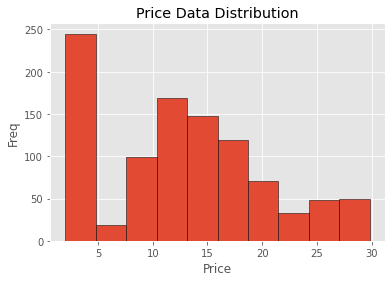

In [13]:
# Visualize the distribution of numerical data

print(f"Price Data skewness : {df['Price'].skew()}")

plt.hist(df['Price'] , edgecolor = 'black' , bins = 10)
plt.xlabel('Price')
plt.ylabel('Freq')
plt.title('Price Data Distribution')
plt.show()

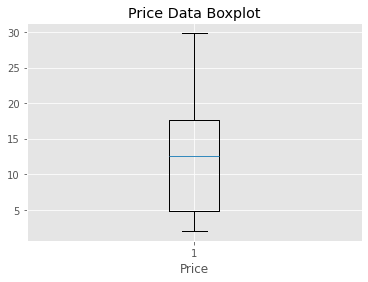

In [14]:
plt.boxplot(df['Price'])
plt.xlabel('Price')
plt.title('Price Data Boxplot')
plt.show()

In [15]:
# Visualize the distribution of numerical data

# separate categorical data from the entire dataset

obj_data = df.select_dtypes('object')

obj_data.head()

,RestaurantID,MenuCategory,MenuItem,Ingredients,Profitability
0,R003,Beverages,Soda,['confidential'],Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",Medium


In [16]:
# check the cardinality

cols = obj_data.columns

for col in cols:
    print(f"{col} Nunique : {obj_data[col].nunique()}")

RestaurantID Nunique : 3
MenuCategory Nunique : 4
MenuItem Nunique : 16
Ingredients Nunique : 4
Profitability Nunique : 3


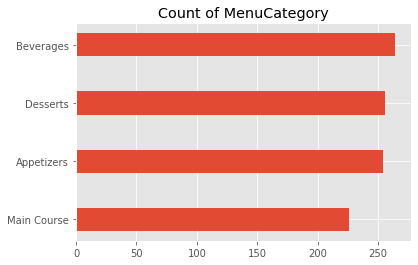

In [17]:
# MenuCategory

data = obj_data['MenuCategory'].value_counts(ascending = True)
plt.barh(data.index , data.values , height = 0.4)
plt.title('Count of MenuCategory')
plt.show()

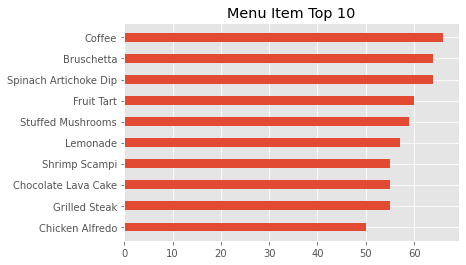

In [18]:
# MenuItem

data = obj_data['MenuItem'].value_counts(ascending = True).head(10)
plt.barh(data.index , data.values , height = 0.4)
plt.title('Menu Item Top 10')
plt.show()

We can see that the menu item are different depending on the specific ingredients

In [19]:
# Ingredients

obj_data.groupby(['Ingredients' , 'MenuItem'])['MenuItem'].count()

Ingredients                                             MenuItem             
['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Parmesan']  Chicken Alfredo          50
                                                        Grilled Steak            55
                                                        Shrimp Scampi            55
                                                        Vegetable Stir-Fry       66
['Chocolate', 'Butter', 'Sugar', 'Eggs']                Chocolate Lava Cake      55
                                                        Fruit Tart               60
                                                        New York Cheesecake      71
                                                        Tiramisu                 70
['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']            Bruschetta               64
                                                        Caprese Salad            67
                                                        Spinach Artichoke Dip    6

If the price difference between the same ingredient groups is not large and the price difference between groups is clear

--> We can group menu items according to ingredients

There is not much difference between the same groups , and the difference between the groups is evident.

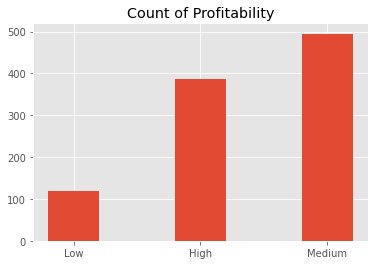

In [22]:
# Profitability

data = obj_data['Profitability'].value_counts(ascending = True)
plt.bar(data.index , data.values , width = 0.4)
plt.title('Count of Profitability')
plt.show()

### Preprocessing

In [23]:
# drop ID
df.drop(['RestaurantID'] , axis = 1 , inplace = True)

In [24]:
# Grouping

for i in range(df.shape[0]):
    if df.loc[i , 'MenuCategory'] == 'Beverages':
        df.loc[i , 'MenuItem'] = 'A'
    elif df.loc[i , 'MenuCategory'] == 'Appetizers':
        df.loc[i , 'MenuItem'] = 'B'
    elif df.loc[i , 'MenuCategory'] == 'Desserts':
        df.loc[i , 'MenuItem'] = 'C'
    else:
        df.loc[i , 'MenuItem'] = 'D'

In [25]:
# Encoding

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['MenuCategory'] = encoder.fit_transform(df['MenuCategory'])
df['MenuItem'] = encoder.fit_transform(df['MenuItem'])
df['Ingredients'] = encoder.fit_transform(df['Ingredients'])

# target value encoding

df['Profitability'] = encoder.fit_transform(df['Profitability'])

In [26]:
df.head()

,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,1,0,3,2.55,1
1,0,1,2,11.12,2
2,2,2,1,18.66,0
3,3,3,0,29.55,0
4,3,3,0,17.73,2


### Modeling

In [27]:
# set the value of y

target = df['Profitability']
df.drop(['Profitability'] , axis = 1 , inplace = True)

In [28]:
# using xgb model

import xgboost as xgb

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , classification_report

In [29]:
# split data into train and test data.

trainX , testX , trainY , testY = train_test_split(df , target , test_size = 0.2 , random_state = 42)

In [30]:
model = xgb.XGBClassifier()

model.fit(trainX , trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [31]:
# Normal Model evaluation

print(f"train data r2 : {model.score(trainX , trainY)}")
print(f"test data r2 : {model.score(testX , testY)}")

y_pred = model.predict(testX)

print(classification_report(testY , y_pred))

train data r2 : 0.93
test data r2 : 0.91
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        77
           1       0.88      0.56      0.68        25
           2       0.92      0.97      0.95        98

    accuracy                           0.91       200
   macro avg       0.90      0.83      0.85       200
weighted avg       0.91      0.91      0.90       200



We can see that the f1 score is low on specific class.

so , it seems that the imbalance in the class needs to be resolved.

In [32]:
# Oversampling

%pip install imblearn

from imblearn.over_sampling import SMOTE


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 258.3/258.3 kB 1.1 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


We can use SMOTE to solve this problem.

In [33]:
smote = SMOTE()

df_resampled , target_resampled = smote.fit_resample(df , target)

In [34]:
# check the data size.

print(f"Data size before Oversampling : {df.shape}")
print(f"Data size before Oversampling : {target.shape}")
print(f"Data size after Oversampling : {df_resampled.shape}")
print(f"Data size after Oversampling : {target_resampled.shape}")

Data size before Oversampling : (1000, 4)
Data size before Oversampling : (1000,)
Data size after Oversampling : (1485, 4)
Data size after Oversampling : (1485,)


Using SMOTE , we can see that the imbalance between classes has been resolved.

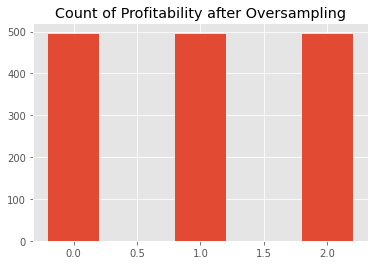

In [35]:
# Profitability

data = target_resampled.value_counts()
plt.bar(data.index , data.values , width = 0.4)
plt.title('Count of Profitability after Oversampling')
plt.show()

In [36]:
trainX , testX , trainY , testY = train_test_split(df_resampled , target_resampled 
                                                   , test_size = 0.2 , random_state = 42)

In [37]:
model = xgb.XGBClassifier()

model.fit(trainX , trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
# Model evaluation

print(f"train data r2 : {model.score(trainX , trainY)}")
print(f"test data r2 : {model.score(testX , testY)}")

y_pred = model.predict(testX)

print(classification_report(testY , y_pred))

train data r2 : 0.9048821548821548
test data r2 : 0.8619528619528619
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        91
           1       0.90      0.75      0.82       109
           2       0.83      0.94      0.88        97

    accuracy                           0.86       297
   macro avg       0.86      0.87      0.86       297
weighted avg       0.87      0.86      0.86       297



We can see that it's generalized as a whole.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

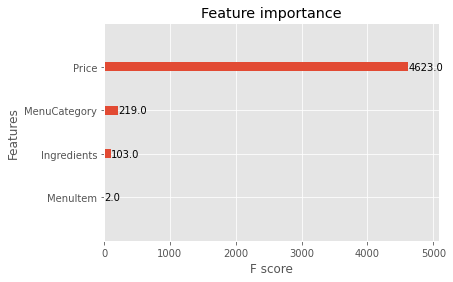

In [39]:
xgb.plot_importance(model)

### HyperParameter Tuning

In [40]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits = 5)

In [41]:
model = xgb.XGBClassifier()

params = {
    'n_estimators' : [100 , 200 , 300] ,
    'max_depth' : [3 , 7] ,
    'min_child_weight' : [1 , 3] ,
    'colsample_bytree' : [0.5 , 0.8]
}

gcv = GridSearchCV(model , param_grid = params , cv = kfold , scoring = 'accuracy' ,
                  verbose = 1)
gcv.fit(trainX , trainY)

best = gcv.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [42]:
print(f"best model score : {gcv.best_score_}")
print(f"params : {gcv.best_params_}")

best model score : 0.8829876254299187
params : {'colsample_bytree': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}


In [43]:
model = xgb.XGBClassifier(
    n_estimators = 100 ,
    max_depth = 3 ,
    min_child_weight = 1 ,
    colsample_bytree = 0.8
)

model.fit(trainX , trainY)

# Model evaluation

print(f"train data r2 : {model.score(trainX , trainY)}")
print(f"test data r2 : {model.score(testX , testY)}")

y_pred = model.predict(testX)

print(classification_report(testY , y_pred))

train data r2 : 0.8956228956228957
test data r2 : 0.8518518518518519
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        91
           1       0.92      0.71      0.80       109
           2       0.79      0.95      0.86        97

    accuracy                           0.85       297
   macro avg       0.86      0.86      0.85       297
weighted avg       0.86      0.85      0.85       297



Through the hyperparameter tuning using GridSearchCV , we can see that not only Price but also other features are better reflected in the model.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

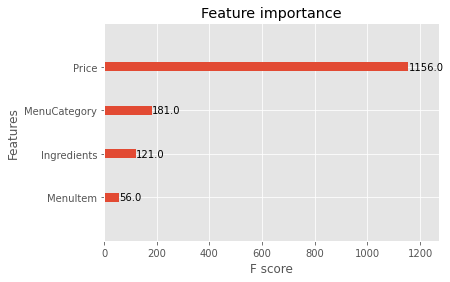

In [44]:
xgb.plot_importance(model)